### CSCE 633 - Machine Learning HW5 - Multi Modal Classification

In [1]:
import torch
import numpy as np
import pandas as pd


In [2]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [3]:
import os 
os.listdir('/kaggle/input/mnist-data')

['x_train_sp.npy',
 'x_test_sp.npy',
 'y_train.csv',
 'x_train_wr.npy',
 'x_test_wr.npy']

### Load Dataset 

In [4]:
#Loading data from CSV files
X_train_wr = np.load('/kaggle/input/mnist-data/x_train_wr.npy')
X_train_sp = np.load('/kaggle/input/mnist-data/x_train_sp.npy')
X_test_wr = np.load('/kaggle/input/mnist-data/x_test_wr.npy')
X_test_sp = np.load('/kaggle/input/mnist-data/x_test_sp.npy')
y_training = pd.read_csv('/kaggle/input/mnist-data/y_train.csv')['label'].values

In [5]:
validataion_size = 0.2
batch_size = 128

In [6]:
#split into training and validation sets
x_train_wr, x_val_wr = train_test_split(X_train_wr, test_size=validataion_size, random_state=42)
x_train_sp, x_val_sp = train_test_split(X_train_sp, test_size=validataion_size, random_state=42)
y_train, y_val = train_test_split(y_training, test_size=validataion_size, random_state=42)

In [7]:
type(x_train_wr)

numpy.ndarray

In [8]:
#create data loaders
x_train_wr_tensor = torch.tensor(x_train_wr.reshape(-1, 1, 28, 28), dtype=torch.float32)
x_val_wr_tensor = torch.tensor(x_val_wr.reshape(-1,1,28,28), dtype=torch.float32)
x_test_wr_tensor = torch.tensor(X_test_wr.reshape(-1,1,28,28), dtype=torch.float32)
x_train_sp_tensor = torch.tensor(x_train_sp, dtype=torch.float32)
x_val_sp_tensor = torch.tensor(x_val_sp, dtype=torch.float32)
x_test_sp_tensor = torch.tensor(X_test_sp, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


train_dataset = TensorDataset(x_train_wr_tensor, x_train_sp_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_wr_tensor, x_val_sp_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_wr_tensor, x_test_sp_tensor)

#creating dataset in required format 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define Encoder Models

In [32]:
class ImageEncoder(nn.Module):
    def __init__(self, num_classes=10):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x) 
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [35]:
class AudioEncoder(nn.Module):
    def __init__(self):
        super(AudioEncoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.calculate_output_size()
        
        self.fc1 = nn.Linear(self.output_size, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def calculate_output_size(self):
        with torch.no_grad():
            input_check = torch.randn(1, 1, 507)
            x = self.conv1(input_check)
            x = self.pool(nn.functional.relu(self.conv2(x)))
            x = self.pool(nn.functional.relu(self.conv3(x)))  
            self.output_size = x.view(x.size(0), -1).shape[1]
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))  
        
        x = x.view(x.size(0), -1)
        
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



### Defining Fusion Model 

takes embeddings for image and audio encoder and fuses them to a single space, uses the fused embeddings for training

In [36]:
class FusionModel(nn.Module):
    def __init__(self, image_encoder, audio_encoder, num_classes=10):
        super(FusionModel, self).__init__()
        self.image_encoder = image_encoder
        self.audio_encoder = audio_encoder
        self.fc_image = nn.Linear(image_encoder.fc2.out_features, 128)
        self.fc_audio = nn.Linear(audio_encoder.fc2.out_features, 128)
        self.fusion = nn.Linear(256, 128)
        self.classifier = nn.Linear(128, num_classes) 

    def forward(self, images, audio):

        image_embedding = self.image_encoder(images)
        audio_embedding = self.audio_encoder(audio)

    
        image_embedding = self.fc_image(image_embedding)
        audio_embedding = self.fc_audio(audio_embedding)
        
        fused_embedding = torch.cat((image_embedding, audio_embedding), dim=1)
        fused_embedding = self.fusion(fused_embedding)
        
        output = self.classifier(fused_embedding)

        return output


In [37]:
image_encoder = ImageEncoder()
audio_encoder = AudioEncoder()

fusion_model = FusionModel(image_encoder, audio_encoder)
model_fusion1 = train_and_eval(10,'adam', 0.001, image_encoder, audio_encoder, fusion_model)  # CHECK HERE = to run this, first run the cell below 

Epoch 1: Train Accuracy: 0.8701, Val Accuracy: 0.9682, F1 Score: 0.9679
Epoch 2: Train Accuracy: 0.9806, Val Accuracy: 0.9871, F1 Score: 0.9870
Epoch 3: Train Accuracy: 0.9884, Val Accuracy: 0.9892, F1 Score: 0.9893
Epoch 4: Train Accuracy: 0.9924, Val Accuracy: 0.9913, F1 Score: 0.9913
Epoch 5: Train Accuracy: 0.9941, Val Accuracy: 0.9902, F1 Score: 0.9902
Epoch 6: Train Accuracy: 0.9963, Val Accuracy: 0.9921, F1 Score: 0.9921
Epoch 7: Train Accuracy: 0.9958, Val Accuracy: 0.9915, F1 Score: 0.9915
Epoch 8: Train Accuracy: 0.9962, Val Accuracy: 0.9919, F1 Score: 0.9919
Epoch 9: Train Accuracy: 0.9975, Val Accuracy: 0.9940, F1 Score: 0.9940
Epoch 10: Train Accuracy: 0.9973, Val Accuracy: 0.9921, F1 Score: 0.9921


In [14]:
def train_and_eval(epochs, optimizer, learning_rate, encoder_image, encoder_audio, model_fusion):
    # Set the device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    fusion_model.to(device)

    # Define the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    if optimizer == 'adam':
        optimizer = optim.Adam(model_fusion.parameters(), lr=learning_rate)
    if optimizer == 'sgd':
        optimizer = optim.SGD(model_fusion.parameters(), lr=learning_rate, momentum=0.9)

    num_epochs = epochs
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        fusion_model.train()  # Set the model to training mode
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        val_preds = []
        val_labels = []

    # Training loop
        for images, audio, labels in train_loader:
            images = images.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model_fusion(images, audio)

            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels).item()
       
        fusion_model.eval()  
        with torch.no_grad():
            for images, audio, labels in val_loader:
                images = images.to(device)
                audio = audio.to(device)
                labels = labels.to(device)

                outputs = model_fusion(images, audio)

                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels).item()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

    
        train_acc /= len(train_loader.dataset)
        val_acc /= len(val_loader.dataset)
        val_f1 = f1_score(val_labels, val_preds, average='macro', labels=np.unique(val_preds))

        print(f"Epoch {epoch+1}: Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(fusion_model.state_dict(), "model.pth")
    return model_fusion
    
    

In [53]:
image_encoder = ImageEncoder()
audio_encoder = AudioEncoder()
fusion_model = FusionModel(image_encoder, audio_encoder)
model_fusion2 = train_and_eval(10,'sgd', 0.001, image_encoder, audio_encoder, fusion_model)

Epoch 1: Train Accuracy: 0.1120, Val Accuracy: 0.1138, F1 Score: 0.2043
Epoch 2: Train Accuracy: 0.1120, Val Accuracy: 0.1138, F1 Score: 0.2043
Epoch 3: Train Accuracy: 0.1120, Val Accuracy: 0.1138, F1 Score: 0.2043
Epoch 4: Train Accuracy: 0.1120, Val Accuracy: 0.1138, F1 Score: 0.2043
Epoch 5: Train Accuracy: 0.1123, Val Accuracy: 0.1139, F1 Score: 0.1040
Epoch 6: Train Accuracy: 0.1606, Val Accuracy: 0.2773, F1 Score: 0.2782
Epoch 7: Train Accuracy: 0.2568, Val Accuracy: 0.3207, F1 Score: 0.2773
Epoch 8: Train Accuracy: 0.4961, Val Accuracy: 0.7114, F1 Score: 0.6975
Epoch 9: Train Accuracy: 0.7644, Val Accuracy: 0.8448, F1 Score: 0.8416
Epoch 10: Train Accuracy: 0.8583, Val Accuracy: 0.9031, F1 Score: 0.9019


In [54]:
image_encoder = ImageEncoder()
audio_encoder = AudioEncoder()
fusion_model = FusionModel(image_encoder, audio_encoder)
model_fusion3 = train_and_eval(10,'adam', 0.01, image_encoder, audio_encoder, fusion_model)

Epoch 1: Train Accuracy: 0.7145, Val Accuracy: 0.9223, F1 Score: 0.9214
Epoch 2: Train Accuracy: 0.9105, Val Accuracy: 0.9405, F1 Score: 0.9396
Epoch 3: Train Accuracy: 0.9276, Val Accuracy: 0.9403, F1 Score: 0.9396
Epoch 4: Train Accuracy: 0.9348, Val Accuracy: 0.9393, F1 Score: 0.9387
Epoch 5: Train Accuracy: 0.9365, Val Accuracy: 0.9523, F1 Score: 0.9522
Epoch 6: Train Accuracy: 0.9409, Val Accuracy: 0.9511, F1 Score: 0.9504
Epoch 7: Train Accuracy: 0.9452, Val Accuracy: 0.9511, F1 Score: 0.9507
Epoch 8: Train Accuracy: 0.9463, Val Accuracy: 0.9621, F1 Score: 0.9618
Epoch 9: Train Accuracy: 0.9477, Val Accuracy: 0.9541, F1 Score: 0.9537
Epoch 10: Train Accuracy: 0.9470, Val Accuracy: 0.9603, F1 Score: 0.9599


In [55]:
#increased learning rate to 0.1
image_encoder = ImageEncoder()
audio_encoder = AudioEncoder()
fusion_model = FusionModel(image_encoder, audio_encoder)
model_fusion4 = train_and_eval(10,'adam', 0.1, image_encoder, audio_encoder, fusion_model)

Epoch 1: Train Accuracy: 0.0990, Val Accuracy: 0.1029, F1 Score: 0.1866
Epoch 2: Train Accuracy: 0.1031, Val Accuracy: 0.1138, F1 Score: 0.2043
Epoch 3: Train Accuracy: 0.1029, Val Accuracy: 0.0949, F1 Score: 0.1734
Epoch 4: Train Accuracy: 0.1008, Val Accuracy: 0.0995, F1 Score: 0.1810
Epoch 5: Train Accuracy: 0.1020, Val Accuracy: 0.0986, F1 Score: 0.1795
Epoch 6: Train Accuracy: 0.1011, Val Accuracy: 0.0997, F1 Score: 0.1813
Epoch 7: Train Accuracy: 0.1016, Val Accuracy: 0.0949, F1 Score: 0.1734
Epoch 8: Train Accuracy: 0.1035, Val Accuracy: 0.0986, F1 Score: 0.1795
Epoch 9: Train Accuracy: 0.1006, Val Accuracy: 0.0913, F1 Score: 0.1674
Epoch 10: Train Accuracy: 0.0993, Val Accuracy: 0.0913, F1 Score: 0.1674


In [56]:
#increased epochs to 20
image_encoder = ImageEncoder()
audio_encoder = AudioEncoder()
fusion_model = FusionModel(image_encoder, audio_encoder)
model_fusion5 = train_and_eval(20,'adam', 0.001, image_encoder, audio_encoder, fusion_model)

Epoch 1: Train Accuracy: 0.8588, Val Accuracy: 0.9780, F1 Score: 0.9779
Epoch 2: Train Accuracy: 0.9820, Val Accuracy: 0.9877, F1 Score: 0.9876
Epoch 3: Train Accuracy: 0.9901, Val Accuracy: 0.9902, F1 Score: 0.9902
Epoch 4: Train Accuracy: 0.9928, Val Accuracy: 0.9898, F1 Score: 0.9897
Epoch 5: Train Accuracy: 0.9939, Val Accuracy: 0.9912, F1 Score: 0.9912
Epoch 6: Train Accuracy: 0.9956, Val Accuracy: 0.9920, F1 Score: 0.9920
Epoch 7: Train Accuracy: 0.9965, Val Accuracy: 0.9923, F1 Score: 0.9923
Epoch 8: Train Accuracy: 0.9967, Val Accuracy: 0.9902, F1 Score: 0.9902
Epoch 9: Train Accuracy: 0.9967, Val Accuracy: 0.9932, F1 Score: 0.9932
Epoch 10: Train Accuracy: 0.9968, Val Accuracy: 0.9922, F1 Score: 0.9922
Epoch 11: Train Accuracy: 0.9969, Val Accuracy: 0.9936, F1 Score: 0.9936
Epoch 12: Train Accuracy: 0.9972, Val Accuracy: 0.9927, F1 Score: 0.9927
Epoch 13: Train Accuracy: 0.9976, Val Accuracy: 0.9928, F1 Score: 0.9929
Epoch 14: Train Accuracy: 0.9984, Val Accuracy: 0.9943, F1 S

### Get Embeddings for Images and Audio

In [40]:
#get embeddings 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_embeddings =[]
audio_embeddings=[]
label_list =[]
for images, audio, labels in train_loader:
        images = images.to(device)
        audio = audio.to(device)
        labels = labels.to(device)

        image_embeddings.append(model_fusion1.image_encoder(images))
        audio_embeddings.append(model_fusion1.audio_encoder(audio))
        label_list.extend(labels.tolist())

### Run the model on test dataset 

stores the test_data predictions in csv file

In [57]:
model_fusion5.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List to store predictions
predictions = []
row_ids = []

for i, (images, audio) in enumerate(test_loader):
    images = images.to(device)
    audio = audio.to(device)

    with torch.no_grad():
        outputs = model_fusion5(images, audio)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        predictions.extend(predicted_labels.cpu().numpy())

row_ids = list(range(len(test_dataset)))

submission_df = pd.DataFrame({'row_id': row_ids, 'Digit_Probability': predictions})

submission_df.to_csv('Neha_Manghnani_preds_updated4.csv', index=False)

In [41]:
image_embeddings_tensor = torch.cat(image_embeddings, dim=0)
audio_embeddings_tensor = torch.cat(audio_embeddings, dim=0)

In [42]:
image_embeddings_np = image_embeddings_tensor.detach().numpy()
audio_embeddings_np = audio_embeddings_tensor.detach().numpy()

In [43]:
labels = np.array(label_list)

### Get the t-SNE embeddings 

In [44]:
# t-SNE for image embeddings
tsne_image = TSNE(n_components=2, random_state=42)
image_embeddings_tsne = tsne_image.fit_transform(image_embeddings_np)

# t-SNE for audio embeddings
tsne_audio = TSNE(n_components=2, random_state=42)
audio_embeddings_tsne = tsne_audio.fit_transform(audio_embeddings_np)

In [45]:
image_embeddings_tsne

array([[  3.2172635, -14.626414 ],
       [ 35.844326 , -69.14     ],
       [  1.5304756,  50.048763 ],
       ...,
       [-27.871883 ,  60.24507  ],
       [ 15.642994 ,  -1.171491 ],
       [ 36.224415 , -57.58134  ]], dtype=float32)

In [46]:
audio_embeddings_tsne

array([[-41.053654 , -14.153796 ],
       [ 12.55001  ,   6.1185393],
       [ 21.080963 , -12.17891  ],
       ...,
       [-38.751488 ,  42.212162 ],
       [-43.083057 ,  44.61556  ],
       [ 51.917435 , -54.772137 ]], dtype=float32)

### t-SNE visualization 

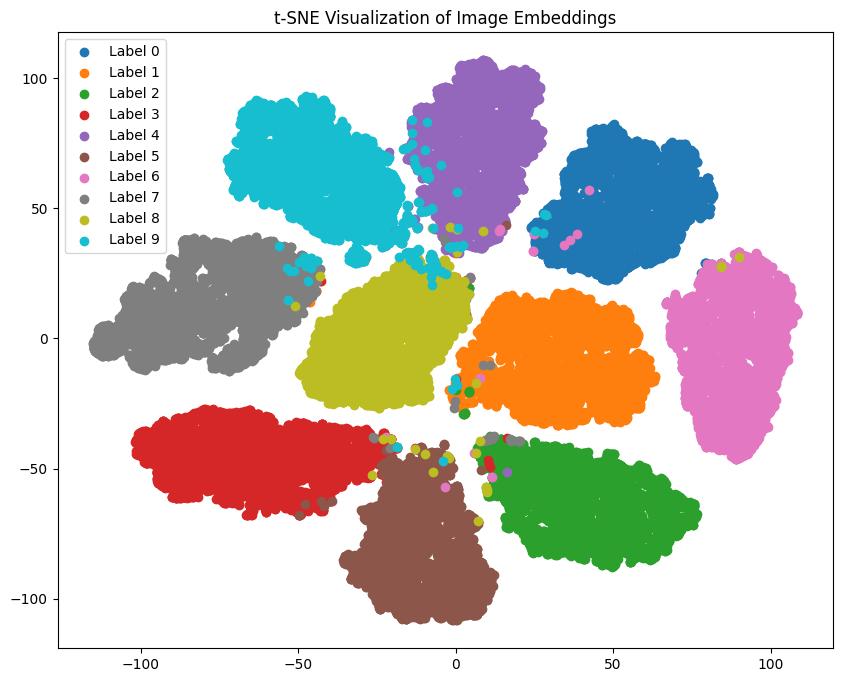

In [47]:
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(image_embeddings_tsne[indices, 0], image_embeddings_tsne[indices, 1], label=f'Label {label}')
plt.title('t-SNE Visualization of Image Embeddings')
plt.legend()
plt.show()

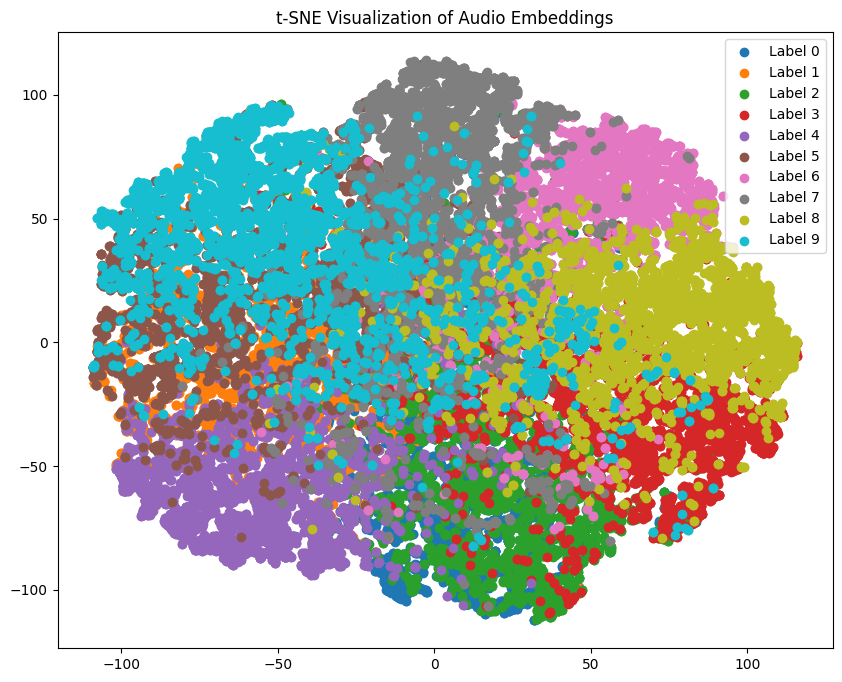

In [48]:
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(audio_embeddings_tsne[indices, 0], audio_embeddings_tsne[indices, 1], label=f'Label {label}')
plt.title('t-SNE Visualization of Audio Embeddings')
plt.legend()
plt.show()

### k-means clusters visualization 

In [49]:
kmeans = KMeans(n_clusters=10, random_state=42)
image_clusters = kmeans.fit_predict(image_embeddings_tsne)

audio_clusters = kmeans.fit_predict(audio_embeddings_tsne)

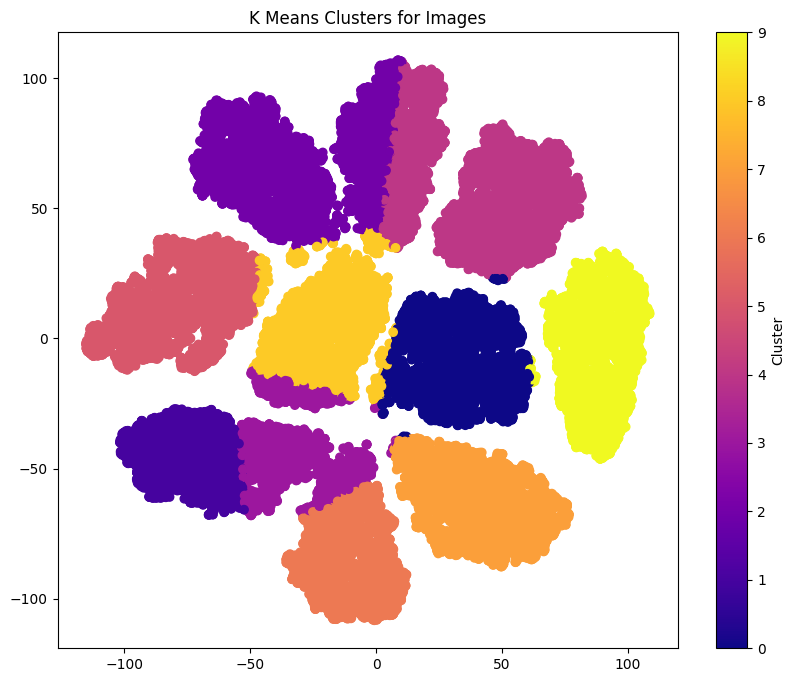

In [50]:
plt.figure(figsize=(10, 8))
plt.scatter(image_embeddings_tsne[:, 0], image_embeddings_tsne[:, 1], c=image_clusters, cmap='plasma')
plt.title('K Means Clusters for Images')
plt.colorbar(label='Cluster')
plt.show()

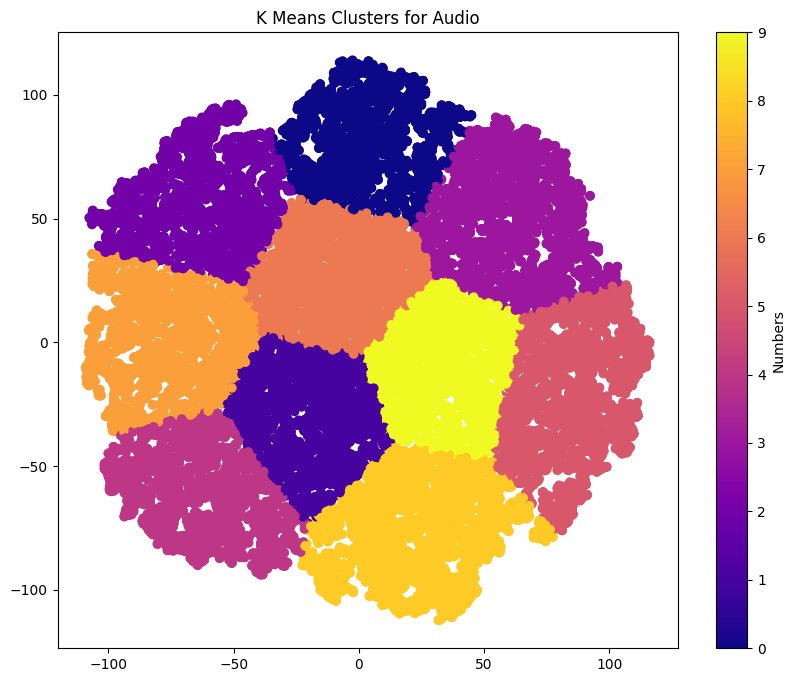

In [51]:
plt.figure(figsize=(10, 8))
plt.scatter(audio_embeddings_tsne[:, 0], audio_embeddings_tsne[:, 1], c=audio_clusters, cmap='plasma')
plt.title('K Means Clusters for Audio')
plt.colorbar(label='Numbers')
plt.show()

Q - Did the model extract clusters associated with the digit labels?

Answer - Yes, as seen in the figure above, separate distinct clusters are made for every digit from 0 to 9. Hence, it is seen that the model is able to extract separate clusters for every labelled digit. 


Q - Compare the clustering result of audio and image embedding. Explain your observation.

Comparing the t-SNE clusters, we see that the image embeddings are more clearly dissociated into different clusters compared to the audio embeddings. In the image k-means clusters majority of the points are assigned to associated clusters with an exception of a few. The k-Means results of audio embeddings also have clear clusters with the data points clearly associated in different clusters but since the t-SNE distribution of audio embeddings represents lower homogenity in the data, the k-means results of audio embeddingss won't be a good indicator of the performance. 
In conclusion, both the image and audio encoder perform well in providing embeddings which give good clustering results. However, the image encoder is more robust in performance compared to the audio encoder. 